In [1]:
h = open('ham_data.txt', encoding='utf-8')  # 正常邮件
s = open('spam_data.txt', encoding='utf-8') # 垃圾邮件
h, s

(<_io.TextIOWrapper name='ham_data.txt' mode='r' encoding='utf-8'>,
 <_io.TextIOWrapper name='spam_data.txt' mode='r' encoding='utf-8'>)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
from nltk.corpus import stopwords
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn import model_selection
from sklearn import svm
from nltk import word_tokenize
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer  

In [3]:
h_data = h.readlines()
s_data = s.readlines()
h_data[0:3], s_data[0:3] # 查看一下前 3 封邮件为例


(['讲的是孔子后人的故事。一个老领导回到家乡，跟儿子感情不和，跟贪财的孙子孔为本和睦。 老领导的弟弟魏宗万是赶马车的。 有个洋妞大概是考察民俗的，在他们家过年。 孔为本总想出国，被爷爷教育了。 最后，一家人基本和解。 顺便问另一类电影，北京青年电影制片厂的。中越战背景。一军人被介绍了一个对象，去相亲。女方是军队医院的护士，犹豫不决，总是在回忆战场上负伤的男友，好像还没死。最后 男方表示理解，归队了。\n',
  '不至于吧，离开这个破公司就没有课题可以做了？ 谢谢大家的关心，她昨天晚上睡的很好。MM她自己已经想好了。见机行事吧，拿到相关的能出来做论文的材料，就马上辞职。 唉！看看吧，说不定还要各为XDJM帮出出找工作的主意呢。MM学通信的，哈尔滨工程大学的研究生，不想在哈碌碌无为的做设计，因此才出来的。先谢谢了啊。！！！ 本人语文不好，没加标点。辛苦那些看不懂的XDJM么了。\n',
  '生一个玩玩，不好玩了就送人 第一，你要知道，你们恋爱前，你爹妈对她是毫无意义的。没道理你爹妈就要求她生孩子，她就得听话。换句话说，你岳父母要未来孩子跟妈姓，你做的到吗？夫妻是平等的。如果你没办法答应岳父母，她干吗答应你爹妈呢？ 第二，有了孩子你养不养的起？不是说想生就生，图你爹妈一个高兴，如果没有房子，没有充足的财力，生孩子只会带给你们更多的困难，生小孩容易，养小孩难啊。\n'],
 ['有情之人，天天是节。一句寒暖，一线相喧；一句叮咛，一笺相传；一份相思， 一心相盼；一份爱意，一生相恋。 搜寻201:::http://201.855.com 在此祝大家七夕情人快乐! 搜寻201友情提示::: 2005年七夕情人节：8月11日――别忘了给她（他）送祝福哦！\n',
  '我司是一家实业贸易定税企业；有余额票向外开 费用相对较低，此操作方式可以为贵公司（工厂） 节约部分税金。 公司本着互利互惠的原则,真诚期待你的来电!!! 联系: 王生   TEL: --13528886061\n',
  '本公司有部分普通发票（商品销售发票）增值税发票及海关代征增值税专用缴款书及其它服务行业发票, 公路、内河运输发票。可以以低税率为贵公司代开，本公司具有内、外贸生意实力，保证我司开具的票据的真实性。 希望可以合作!共同发展!敬侯您的来电洽谈、咨询！ 联系人：李先生      联系电话：1363

In [4]:
import numpy as np

h_labels = np.ones(len(h_data)).tolist() # 生成全 1 的正标签list
s_labels = np.zeros(len(s_data)).tolist() # 生成全 0 的负标签list
# 拼接正负样本集和标签集合到一起
datas = h_data + s_data
labels = h_labels + s_labels


In [5]:
from sklearn.model_selection import train_test_split

train_d, test_d, train_y, test_y = train_test_split(datas, labels, test_size=0.2, random_state=5)


In [6]:
import jieba

def tokenize_words(corpus):
    tokenized_words = jieba.cut(corpus,cut_all=False) # 调用 jieba 分词
    tokenized_words = [token.strip() for token in tokenized_words] # 去掉回车符，转为list类型
    return tokenized_words

In [7]:
def remove_stopwords(corpus): # 函数输入为全部样本集（包括训练和测试）
    sw = open('stop_word.txt', encoding='utf-8') # 加载停用词表
    sw_list = [l.strip for l in sw] # 去掉回车符存放至list中
    # 调用分词函数
    tokenized_data = tokenize_words(corpus)
    # 使用list生成式对停用词进行过滤
    filtered_data = [data for data in tokenized_data if data not in sw_list]
    # 用' '将 filtered_data 串起来赋值给 filtered_datas（不太好介绍，可以看一下下面处理前后的截图对比）
    filtered_datas = ' '.join(filtered_data)
    # 返回是去除停用词后的字符串
    return filtered_datas

In [8]:
from tqdm.notebook import tqdm

def preprocessing_datas(datas):
    preprocessing_datas = []
    # 对 datas 当中的每一个 data 进行去停用词操作
    # 并添加到上面刚刚建立的 preprocessed_datas 当中
    for data in tqdm(datas):
        data = remove_stopwords(data)
        preprocessing_datas.append(data)
    # 返回预处理后的样本集
    return preprocessing_datas


In [9]:
pred_train_d = preprocessing_datas(train_d)
print(pred_train_d[0])
pred_test_d = preprocessing_datas(test_d)
print(pred_test_d[0])

  0%|          | 0/8000 [00:00<?, ?it/s]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\86139\AppData\Local\Temp\jieba.cache
Loading model cost 0.422 seconds.
Prefix dict has been built successfully.


和 是不是 博士 无关  认识 了 一个 女孩 ， 博士 毕业 ，  感觉 平时 她 性格 还 可以 ， 一 谈论 到 学术 就 总是 象 5.4 运动 的 热血青年 那样 ， 很 是 小马 乍行  恨 天低 的 样子 ， 今天 居然 因为 一点 小 事情 在 手机短信 里 和 我 大吵 了 一次 ， 我 在 尽力 克制 自己 ， 可 她 讲话 的 语气 居然 口气 硬得 让 我 吃惊 ， 很 是 恼怒 之极 的 样子 。 我 一直 希望 找个 比较 温柔 点 的 GF ， 可 今天 她 的 表现 真 让 我 感觉 困惑 。 是不是 多数 女博士 的 性格 都 很 强硬 啊 ？ 


  0%|          | 0/2001 [00:00<?, ?it/s]

全球 最大 的 中文 创业 门户 ， 一个 令 全球 震惊 的 成功 秘密 ！  www . zhaozhao360 . com  上班族 另类 火爆 发财 法  将 兼职 变成 创业  你 准备 好了吗 ？  美女 老板 掘 第一桶金  19 岁 小女子 5 年 净赚 30 万  内衣 试穿 妹 试成 白金 丽  中国 新 九大 暴利行业 ！  比尔 ・ 盖茨 怎样 花钱 ？  赚到 500 万 只 因 一条 狗  怎么 把 工资 从 400 变成 40000 


In [10]:
import pandas as pd    
# 使用Pandas创建DataFrame  
data_frame = pd.DataFrame(pred_train_d,columns=['Data'])  
data_frame['Label'] = train_y

print(data_frame)

                                                   Data  Label
0     和 是不是 博士 无关  认识 了 一个 女孩 ， 博士 毕业 ，  感觉 平时 她 性格 ...    1.0
1     pencirl  ( 雪茄 & amp ; 带 你 远走高飞 )  共上站  859  次 ...    1.0
2     尊敬 的 财务 负责人 ( 财务科 ) :  您好 !  因 我 公司 享有 国家 优惠政策...    0.0
3                   深圳 道瑞 国际 货运 有限公司  深圳 道瑞 国际 货运 有限公司     0.0
4     本 公司 主营 国际 、 国内 飞机票 、 包定 国内外 酒店 ， 服务 热情周到 ， 北京...    0.0
...                                                 ...    ...
7995  应该 兴幸 自己 还有 感觉  这才 是 曾经 爱过 呀 … …  曾经 喜欢 一个 男生 ...    1.0
7996  贵 公司 负责人 您好 ： 如此 条 信息 对 您 的 打扰 表示歉意 ，  并 请谅解 。...    0.0
7997  我 喜欢 他 ！ ！ ！  真得 好帅 哦 。 。 。  尤其 是 那种 神经 的 感觉 ，...    1.0
7998  文章 明显 是 编 的 ， 年龄 有 问题 。  抛 去 二十七年 的 岁月 ， 如果 是 ...    1.0
7999  其实 也 是 卖 得 了  只不过 招个 博士 来 做 听 着 好听  反正 现在 博士 也...    1.0

[8000 rows x 2 columns]


In [11]:
# Let's get the length of the messages
data_frame['length'] = data_frame['Data'].apply(len)
data_frame['length'].max()

718

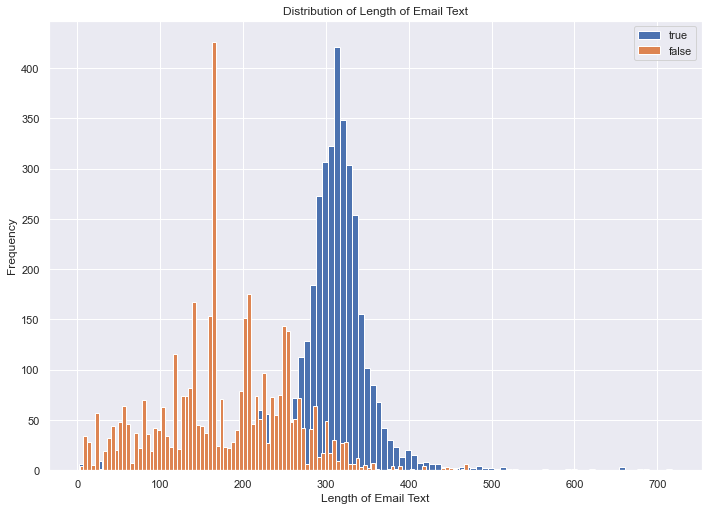

In [12]:
#data_frame['length'].plot(bins=100, kind='hist') 
#Length of characters for ham emails is more as compared to spam emails
sns.set(rc={'figure.figsize':(11.7,8.27)})
ham_messages_length =  data_frame[data_frame['Label']==1] 
spam_messages_length =  data_frame[data_frame['Label']==0]

ham_messages_length['length'].plot(bins=100, kind='hist',label = 'true') 
spam_messages_length['length'].plot(bins=100, kind='hist',label = 'false') 
#sns.distplot(ham_messages_length['length'], bins=10, norm_hist = True, label = 'Ham')
#sns.distplot(spam_messages_length['length'], bins=10, norm_hist = True, label = 'Spam')
plt.title('Distribution of Length of Email Text')
plt.xlabel('Length of Email Text')
plt.legend()


#ax = sns.distplot(ham_words_length, norm_hist = True, bins = 30, label = 'Ham')
#ax = sns.distplot(spam_words_length, norm_hist = True, bins = 30, label = 'Spam')

#plt.legend()
#plt.title('Distribution of Number of Words')
#plt.xlabel('Number of Words')
#plt.show()

In [13]:
#data_frame['spam']==0
data_frame[data_frame['Label']==0.0] .Data.values

ham_words_length = [len(word_tokenize(title)) for title in data_frame[data_frame['Label']==1.0].Data.values]
spam_words_length = [len(word_tokenize(title)) for title in data_frame[data_frame['Label']==0.0].Data.values]
print(max(ham_words_length))
print(max(spam_words_length))

353
152


C:\Users\86139\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\86139\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


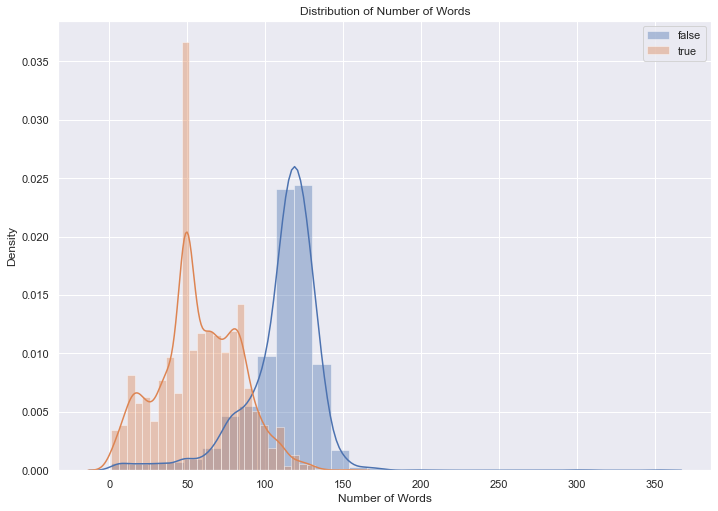

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(ham_words_length, norm_hist = True, bins = 30, label = 'false')
ax = sns.distplot(spam_words_length, norm_hist = True, bins = 30, label = 'true')
#ham_words_length.plot(bins=100, kind='hist',label = 'Ham') 
#spam_words_length.plot(bins=100, kind='hist',label = 'Spam')


plt.title('Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.legend()
                       
plt.show()

Ham Mean: 0.359
Spam Mean: 0.154


C:\Users\86139\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\86139\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


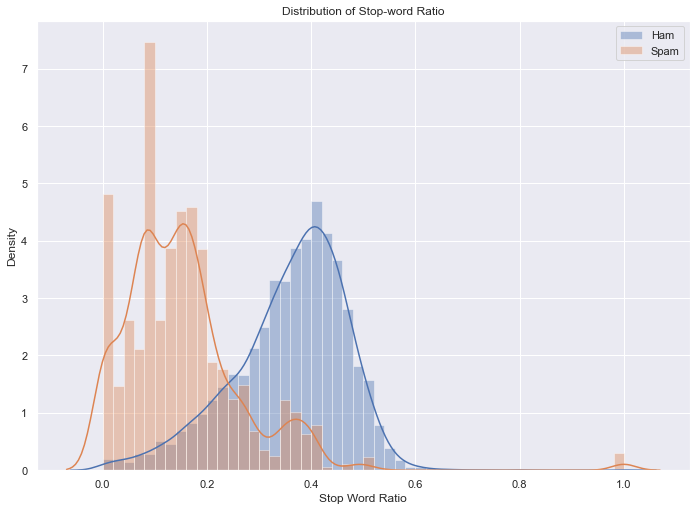

In [15]:
#Checking ratio of stop words
#Both spam and ham email contain stopwords
#All Spam emails contain stop words with a mean of 0.281
#All Ham emails contain stop words with a mean of 0.278
#But we can see from the graph, spam email contain high stop words ratio as compared to ham emails.
from nltk.corpus import stopwords
stop_words = set(stopwords.words('chinese'))
    
    
def stop_words_ratio(x):
    num_total_words = 0
    num_stop_words = 0
    for word in word_tokenize(x):
        if word in stop_words:
            num_stop_words += 1
        num_total_words += 1 
    return num_stop_words/num_total_words


ham_stopwords =data_frame[data_frame['Label']==1.0] .Data.apply(stop_words_ratio)
spam_stopwords = data_frame[data_frame['Label']==0.0] .Data.apply(stop_words_ratio)


sns.distplot(ham_stopwords, norm_hist = True, label = 'Ham')
sns.distplot(spam_stopwords,  label = 'Spam')

print('Ham Mean: {:.3f}'.format(ham_stopwords.values.mean()))
print('Spam Mean: {:.3f}'.format(spam_stopwords.values.mean()))
plt.title('Distribution of Stop-word Ratio')
plt.xlabel('Stop Word Ratio')
plt.legend()

Spam percentage = 50.175000000000004 %
Ham percentage = 49.825 %


C:\Users\86139\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Ham(0) and Spam(1)', ylabel='count'>

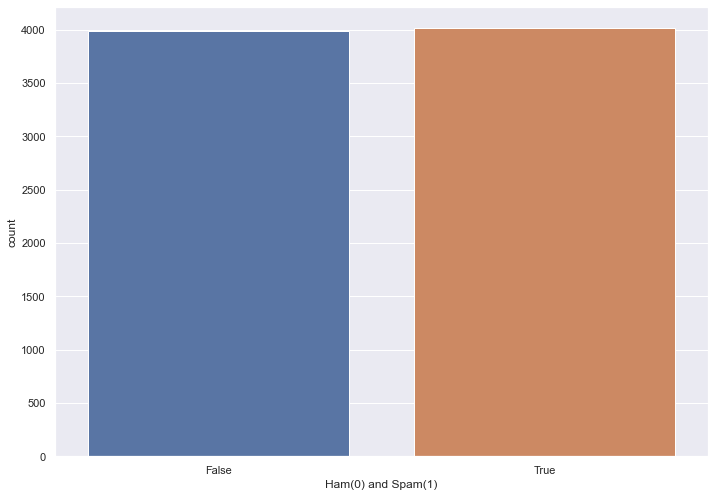

In [16]:
# Let's divide the messages into spam and ham
ham = data_frame[data_frame['Label']==1]
spam = data_frame[data_frame['Label']==0]
spam['length'].plot(bins=60, kind='hist') 
ham['length'].plot(bins=60, kind='hist') 
data_frame['Ham(0) and Spam(1)'] =data_frame['Label']==0
print( 'Spam percentage =', (len(spam) / len(data_frame) )*100,"%")
print( 'Ham percentage =', (len(ham) / len(data_frame) )*100,"%")
sns.countplot(data_frame['Ham(0) and Spam(1)'], label = "Count") 

#word_cloud_obj = generate_word_cloud()
#word_cloud_obj.word_cloud(ham["clean_text"], "ham_word_cloud.png")
#word_cloud_obj.word_cloud(spam["clean_text"], "spam_word_cloud.png")
#text_spam = " ".join(review for review in spam["clean_text"])

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer  

vectorizer = TfidfVectorizer(max_df=0.9, ngram_range=(1, 1), smooth_idf=True, min_df=0.1, norm='l2',   
                                   analyzer="word", tokenizer=None, preprocessor=None, stop_words=None)  


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer  
  
# pred_train_d 是你的文本数据  
vectorizer = TfidfVectorizer(max_df=0.9, ngram_range=(1, 1), smooth_idf=True, min_df=0.1, norm='l2',     
                             analyzer="word", tokenizer=None, preprocessor=None, stop_words=None)  
tfidf_train_features = vectorizer.fit_transform(pred_train_d)  

# 获取特征名称（单词）  
feature_names = vectorizer.get_feature_names()  
  
# 你现在可以使用 feature_names 来获取单词及其对应的权重]
# 创建一个新的空列表来存储单词及其对应的TF-IDF权重  
word_weights = []  
  
# 使用transform方法为每个单词生成权重  
for word in feature_names:  
    weight = vectorizer.transform([word]).toarray()[0]  
    word_weights.append((word, weight))  
  
# 打印每个单词及其权重  
for word, weight in word_weights:  
    print(f"{word}: {weight}")

com: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
http: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
www: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
一个: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
什么: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
公司: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
发票: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
可以: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
如果: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
就是: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
您好: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
我们: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
时候: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
有限公司: [0. 0. 0. 0. 0.

In [19]:
import csv
import pandas as pd
import numpy as np
import jieba
import jieba.analyse
from scipy.sparse import coo_matrix
from sklearn import feature_extraction  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#将文本中的词语转换为词频矩阵 矩阵元素a[i][j] 表示j词在i类文本下的词频
vectorizer = CountVectorizer(max_df=0.96,  min_df=0.06)

#该类会统计每个词语的tf-idf权值
transformer = TfidfTransformer()

#第一个fit_transform是计算tf-idf 第二个fit_transform是将文本转为词频矩阵
tfidf = transformer.fit_transform(vectorizer.fit_transform(pred_train_d))
for n in tfidf[:5]:
    print(n)
print(type(tfidf))

# 获取词袋模型中的所有词语  
word = vectorizer.get_feature_names()
for n in word[:30]:
    print(n)
print("单词数量:", len(word))

#将tf-idf矩阵抽取出来，元素w[i][j]表示j词在i类文本中的tf-idf权重
#X = tfidf.toarray()
y = coo_matrix(tfidf, dtype=np.float32).toarray() #稀疏矩阵 注意float
print(y.shape)
print(y[:5])


  (0, 46)	0.3501000563266893
  (0, 38)	0.4757497168421145
  (0, 28)	0.4757497168421145
  (0, 22)	0.44999479188017527
  (0, 20)	0.33556340976702315
  (0, 7)	0.33114385048735456
  (0, 39)	0.6971487338398278
  (0, 12)	0.7169265254581705
  (0, 45)	0.2595014853642936
  (0, 37)	0.2857587519785452
  (0, 33)	0.22397873970465526
  (0, 30)	0.24284978440788857
  (0, 21)	0.2571071744035237
  (0, 19)	0.4507690014057265
  (0, 18)	0.6142192304197401
  (0, 14)	0.2587647794480482
  (0, 2)	0.16833643478597
  (0, 33)	0.6309014498868367
  (0, 23)	0.7758629779353358
  (0, 45)	0.3528871735352425
  (0, 44)	0.3478352174150179
  (0, 35)	0.6470631933848154
  (0, 23)	0.3745642510690053
  (0, 18)	0.2784185581179951
  (0, 3)	0.2560726529115974
  (0, 2)	0.2289149466378906
<class 'scipy.sparse._csr.csr_matrix'>
020
cn
com
http
mm
re
www
一个
一起
不是
不能
产品
什么
付款
代开
优惠
但是
免费
公司
发票
可以
咨询
因为
国际
大家
如果
就是
已经
希望
广告
单词数量: 56
(8000, 56)
[[0.         0.         0.         0.         0.         0.
  0.         0.33114386 0.       

In [20]:
tfidf_train_features = vectorizer.fit_transform(pred_train_d)
tfidf_train_features

<8000x56 sparse matrix of type '<class 'numpy.int64'>'
	with 47749 stored elements in Compressed Sparse Row format>

In [21]:
np.array(tfidf_train_features.toarray()).shape

(8000, 56)

In [22]:
tfidf_test_features = vectorizer.transform(pred_test_d)
tfidf_test_features

<2001x56 sparse matrix of type '<class 'numpy.int64'>'
	with 11889 stored elements in Compressed Sparse Row format>

In [23]:
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier(loss='hinge')

In [24]:
svm.fit(tfidf_train_features, train_y)

SGDClassifier()

In [25]:
predictions = svm.predict(tfidf_test_features)
predictions

array([0., 1., 1., ..., 0., 0., 0.])

In [26]:
tfidf_test_features

<2001x56 sparse matrix of type '<class 'numpy.int64'>'
	with 11889 stored elements in Compressed Sparse Row format>

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95       987
         1.0       0.95      0.95      0.95      1014

    accuracy                           0.95      2001
   macro avg       0.95      0.95      0.95      2001
weighted avg       0.95      0.95      0.95      2001

test set

Accuracy Score: 0.9465267366316842
F1 Score: 0.9471604938271605
Recall: 0.9457593688362919
Precision: 0.9485657764589516
Confusion matrix, without normalization
[[935  52]
 [ 55 959]]
Normalized confusion matrix
[[0.9473151  0.0526849 ]
 [0.05424063 0.94575937]]


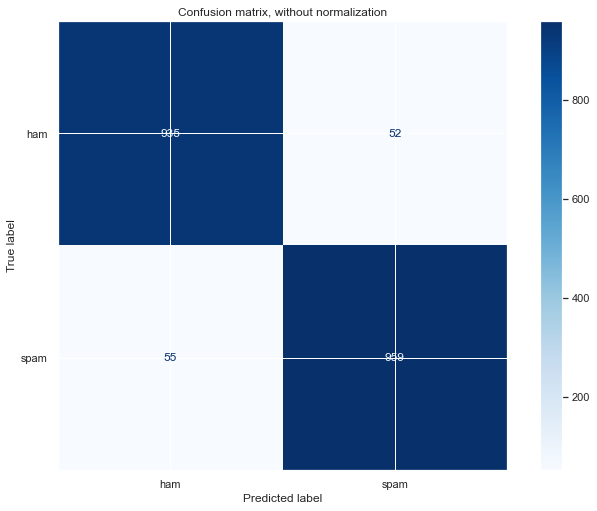

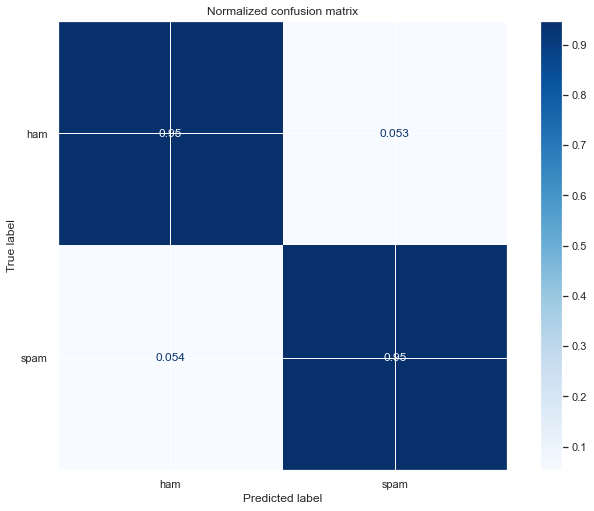

No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.989


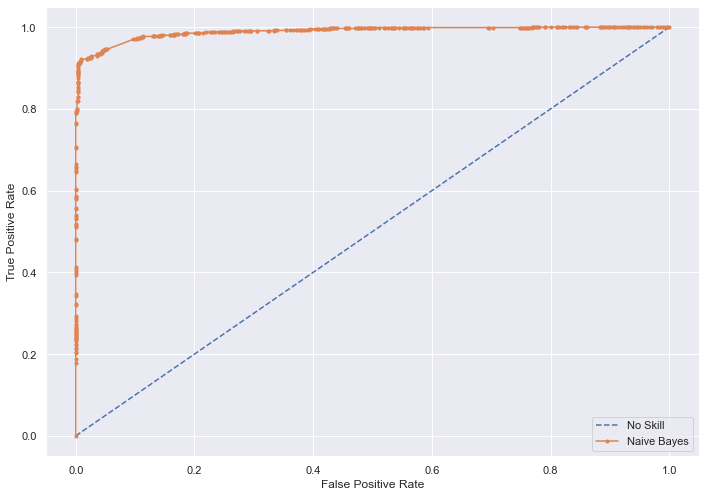

请输入样本编号（0~250）：4
邮件类型： 正常邮件
预测邮件类型： 正常邮件
文本： 一不小心进来了，突然来了感慨，就随便写两句，写给我的20岁。 前几日过生日，有好多人记得，XX：15号晚上大半夜的开完会给我过生日，为了买礼物，差点上课迟到。20岁模样的蜡烛现在仍放在桌上。我没舍得点太长时间。曲奔：16号的凌晨给我打电话，听我说巨多的废话，然后他自己再说一堆废话，感觉好亲切。曾经的XX：一大早上就给我发 众多女性朋友就不用说了，小明，悦悦，超超。。。



In [27]:
        NB_classifier = MultinomialNB(alpha=1, fit_prior=True)
        NB_classifier.fit(tfidf_train_features, train_y)
        # Predicting the Test set results
        y_predict_test = NB_classifier.predict(tfidf_test_features)
        cm = confusion_matrix(test_y, y_predict_test)
        #sns.heatmap(cm, annot=True)
        #Evaluating Model
        print(classification_report(test_y, y_predict_test))
        print("test set")

        print("\nAccuracy Score: " + str(metrics.accuracy_score(test_y, y_predict_test)))
        print("F1 Score: " + str(metrics.f1_score(test_y, y_predict_test)))
        print("Recall: " + str(metrics.recall_score(test_y, y_predict_test)))
        print("Precision: " + str(metrics.precision_score(test_y, y_predict_test)))
        
        class_names = ['ham', 'spam']
        titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
        for title, normalize in titles_options:
            disp = plot_confusion_matrix(NB_classifier,tfidf_test_features , test_y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
            disp.ax_.set_title(title)
            print(title)
            print(disp.confusion_matrix)
        plt.show()
        
        # generate a no skill prediction (majority class)
        ns_probs = [0 for _ in range(len(test_y))]
        # predict probabilities
        lr_probs = NB_classifier.predict_proba(tfidf_test_features)
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        # calculate scores
        ns_auc = roc_auc_score(test_y, ns_probs)
        lr_auc = roc_auc_score(test_y, lr_probs)
        # summarize scores
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print('Naive Bayes: ROC AUC=%.3f' % (lr_auc))
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)
        # plot the roc curve for the model
        pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Naive Bayes')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        # show the legend
        pyplot.legend()
        # show the plot
        pyplot.show()
        id = int(input('请输入样本编号（0~250）：'))
        print('邮件类型：', '垃圾邮件' if test_y[id]==0 else'正常邮件')
        print('预测邮件类型：', '垃圾邮件' if y_predict_test[id]==0 else'正常邮件')
        print('文本：', test_d[id])
        

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       987
         1.0       0.98      0.94      0.96      1014

    accuracy                           0.96      2001
   macro avg       0.96      0.96      0.96      2001
weighted avg       0.96      0.96      0.96      2001

test set

Accuracy Score: 0.9625187406296851
F1 Score: 0.9622926093514329
Recall: 0.9437869822485208
Precision: 0.9815384615384616
Confusion matrix, without normalization
[[935  52]
 [ 55 959]]
Normalized confusion matrix
[[0.9473151  0.0526849 ]
 [0.05424063 0.94575937]]


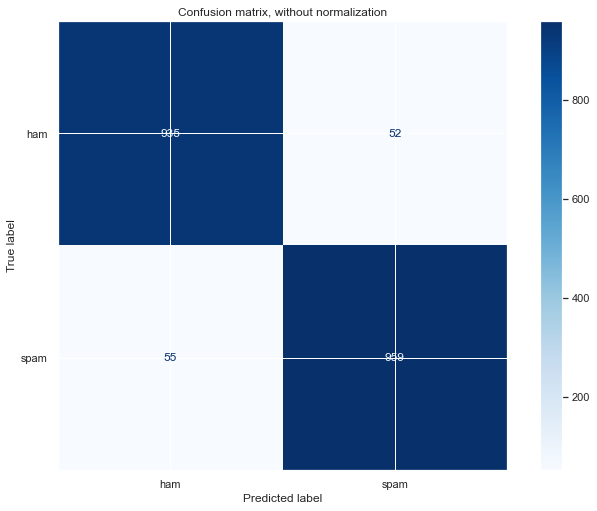

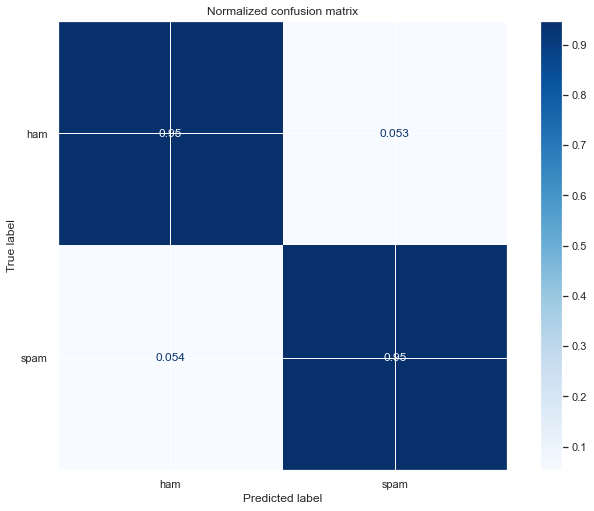

No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.989


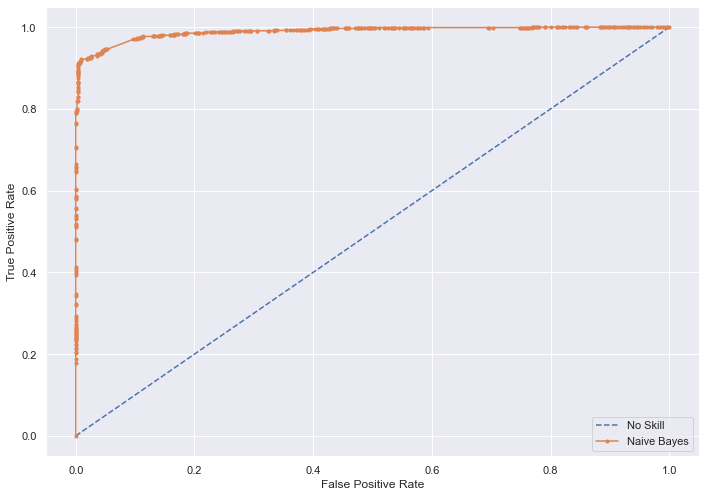

请输入样本编号（0~250）：4
邮件类型： 正常邮件
预测邮件类型： 正常邮件
文本： 一不小心进来了，突然来了感慨，就随便写两句，写给我的20岁。 前几日过生日，有好多人记得，XX：15号晚上大半夜的开完会给我过生日，为了买礼物，差点上课迟到。20岁模样的蜡烛现在仍放在桌上。我没舍得点太长时间。曲奔：16号的凌晨给我打电话，听我说巨多的废话，然后他自己再说一堆废话，感觉好亲切。曾经的XX：一大早上就给我发 众多女性朋友就不用说了，小明，悦悦，超超。。。



In [28]:
        from sklearn.svm import SVC  
  
        params = {'kernel': 'linear', 'C': 50, 'gamma': 10}
        svm_cv = SVC(C=params['C'], kernel=params['kernel'], gamma=params['gamma'], probability=True)  
        svm_cv.fit(tfidf_train_features, train_y)  
        # Predicting the Test set results  
        f_predict_test = svm_cv.predict(tfidf_test_features)  
        cm = confusion_matrix(test_y, f_predict_test)
        #sns.heatmap(cm, annot=True)
        #Evaluating Model
        print(classification_report(test_y, f_predict_test))
        print("test set")

        print("\nAccuracy Score: " + str(metrics.accuracy_score(test_y, f_predict_test)))
        print("F1 Score: " + str(metrics.f1_score(test_y, f_predict_test)))
        print("Recall: " + str(metrics.recall_score(test_y, f_predict_test)))
        print("Precision: " + str(metrics.precision_score(test_y, f_predict_test)))
        
        class_names = ['ham', 'spam']
        titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
        for title, normalize in titles_options:
            disp = plot_confusion_matrix(NB_classifier,tfidf_test_features , test_y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
            disp.ax_.set_title(title)
            print(title)
            print(disp.confusion_matrix)
        plt.show()
        
        # generate a no skill prediction (majority class)
        ns_probs = [0 for _ in range(len(test_y))]
        # predict probabilities
        lr_probs = NB_classifier.predict_proba(tfidf_test_features)
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        # calculate scores
        ns_auc = roc_auc_score(test_y, ns_probs)
        lr_auc = roc_auc_score(test_y, lr_probs)
        # summarize scores
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print('Naive Bayes: ROC AUC=%.3f' % (lr_auc))
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)
        # plot the roc curve for the model
        pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Naive Bayes')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        # show the legend
        pyplot.legend()
        # show the plot
        pyplot.show()
        id = int(input('请输入样本编号（0~250）：'))
        print('邮件类型：', '垃圾邮件' if test_y[id]==0 else'正常邮件')
        print('预测邮件类型：', '垃圾邮件' if f_predict_test[id]==0 else'正常邮件')
        print('文本：', test_d[id])

        

In [29]:
text1="9fja0谷爱凌海清的学霸儿子网易免费邮箱.中国第一大电子邮件服务商网易免费邮箱企业邮箱 VIP邮箱 会员PLUS 海外用户登录 邮箱大师 帮助 登录反馈浏览器不支持或禁止了网页脚本，导致您无法正常登录。如何解除脚本限制 邮箱帐号登录 载入中... 载入中... 载入中...网易首页 网易严选 网易有钱 隐私政策 儿童隐私政策网易公司版权所有&copy;1997- ICP备案 粤B2-20090191-18 粤公网安备 44010602000311 增值电信业务许可证 粤B2-20090191 B2-20090058 （数据来源：艾媒邮箱报告）"
# 假设 tokenize_words 返回一个列表  
result = tokenize_words(text1)  
# 如果需要，可以再将列表转换为字符串  
text = ' '.join(result)  

# 将文本转化为TF-IDF向量    
tfidf_test_features = vectorizer.transform([text])    
    
# 使用SVM模型进行预测    
prediction = svm_cv.predict(tfidf_test_features)    
if prediction==1:  
    print("真实邮件")  
else:
    print("垃圾邮件")


垃圾邮件


In [54]:
import tkinter as tk  
  
root = tk.Tk()  
root.title("邮件分类器")  
  
text_entry = tk.Entry(root, width=100, font=10)    
text_entry.grid(row=1, column=1)  
  
label = tk.Label(root, text="邮件内容:")  # 添加的标签，显示在文本框上方    
label.grid(row=0, column=0)  
  
def submit_button_clicked():  
    text = text_entry.get()    
    # 分词、转换为TF-IDF向量、使用SVM模型预测    
    result = tokenize_words(text)    
    text = ' '.join(result)    
    tfidf_test_features = vectorizer.transform([text])    
    prediction = svm_cv.predict(tfidf_test_features)    
    if prediction == 1:    
        output_label["text"] = "真实邮件"    
    else:    
        output_label["text"] = "垃圾邮件"    
  
submit_button = tk.Button(root, text="提交", command=submit_button_clicked)    
submit_button.grid(row=2, column=2)  
  
output_label = tk.Label(root, text="")    
output_label.grid(row=3, column=1)  
  
root.mainloop()